# Section 2: Text classification

# 2.1	Text classification with Word2Vec

**Importing all important libraries**

In [65]:
import json
import numpy as np
import pandas as pd
import spacy
import gensim.downloader as api  # Pre-trained Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Loading pretrained Word2Vec Model 

In [67]:
print("Loading Word2Vec model... ")
word2vec_model = api.load("word2vec-google-news-300")
print("Word2Vec model loaded successfully!")

Loading Word2Vec model... 
Word2Vec model loaded successfully!


# Loading spaCy Model for Text Preprocessing-English

In [69]:
nlp = spacy.load("en_core_web_sm")

# Loading dataset

In [71]:
file_path = "./stories.json"  
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extracting Relevant Data

In [73]:
story_data = []
for story in data['stories']:
    story_data.append({
        "index": story["index"],
        "text": story["story"],  
        "setting": story["setting"]
    })
df_story = pd.DataFrame(story_data)

In [74]:
df_story.head()

,index,text,setting
0,0,In a reality where pillars of fire had danced ...,post-apocalyptic world
1,1,In an epoch characterized by towering peaks of...,outer space
2,2,"In the midst of a quaint hamlet, nestled betwe...",small town
3,3,"In the heart of an isolated, provincial region...",small town
4,4,"In the pulsating heart of a bustling, steel-cl...",a modern metropolis


# Text Preprocessing Function

In [76]:
def preprocess_text(text):
    """
    Tokenizes text, removes stop words, and returns a list of meaningful words.
    """
    doc = nlp(text.lower())  # Converting to lowercase and process
    words = [token.text for token in doc if token.is_alpha and not token.is_stop]  # Removing punctuation & stopwords
    return words

print("Words/Tokens returned")

Words/Tokens returned


# Function to Get Average Word2Vec Embedding

In [78]:
def get_average_embedding(text):
    """
    Computes the average Word2Vec embedding of a given text in stories.
    """
    words = preprocess_text(text)
    word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    
    if len(word_vectors) == 0:  # If no valid word embeddings are found
        return np.zeros(300)  # Return a zero vector for mkaing it 300
    
    return np.mean(word_vectors, axis=0)  # Compute the average embedding

print("Average Embedding Computed")

Average Embedding Computed


# Applying Word2Vec transformation to each story

In [80]:
from tqdm import tqdm
# Enable tqdm for pandas apply
tqdm.pandas(desc="Processing Embeddings")

# Apply function
df_story["embedding"] = df_story["text"].progress_apply(get_average_embedding)
#df_story["embedding"] = df_story["text"].get_average_embedding)

print("Embedding Computation Completed!")

Processing Embeddings: 100%|██████████████████| 602/602 [00:28<00:00, 21.17it/s]

Embedding Computation Completed!


In [81]:
# Checking shape of the first embedding
print(df_story["embedding"].iloc[0].shape)

(300,)


In [82]:
# Checking all embeddings have the same shape
df_story["embedding"] = df_story["embedding"].apply(lambda x: x if isinstance(x, np.ndarray) and x.shape == (300,) else np.zeros(300))

# Count unique shapes
print(df_story["embedding"].value_counts()) 

embedding
[0.1109717, 0.11191801, 0.023188343, 0.04733856, -0.06494149, -0.027535627, 0.041831885, -0.11917954, 0.096411616, 0.13919921, -0.0011543471, -0.11613629, -0.012416714, 0.07125913, -0.05771521, 0.057971366, 0.014580076, 0.113177225, 0.00079390133, -0.069498606, -0.024580834, 0.09039098, 0.014402734, -0.03603894, 0.015270939, -0.08753262, -0.07545273, 0.033107672, 0.03694958, -0.09405155, -0.015100084, -0.032697402, -0.027733892, 0.020897213, -0.02066792, -0.046365343, 0.04683567, 9.681265e-05, 0.019027442, 0.07050799, 0.07883981, -0.0703288, 0.09285565, -0.04048305, 0.04232731, -0.049588326, -0.090250865, 0.026044736, 0.04951878, 0.047399916, -0.025324516, 0.051400542, -0.021395713, -0.0067980257, 0.01573136, 0.019515008, -0.056897502, -0.1113336, -0.021633467, -0.05742998, -0.026932703, 0.08190338, -0.00864696, -0.09743053, -0.036730174, -0.014419556, -0.038156617, 0.077578776, -0.07190463, 0.02868244, -0.013715744, -0.016839048, 0.048832808, -0.047503475, -0.18017362, -0.07

In [83]:
# Debugging for missing embeddings
print(f"Total missing embeddings: {df_story['embedding'].apply(lambda x: np.all(x == 0)).sum()}")

# Convert list of embeddings into a NumPy array
X = np.vstack(df_story["embedding"].values)

# Printing shape to confirm correct size
print(f"Shape of feature matrix X: {X.shape}")

Total missing embeddings: 0
Shape of feature matrix X: (602, 300)


# Convert categorical target variable "setting" into numerical labels

In [85]:
label_mapping = {
    "post-apocalyptic world": 0,
    "small town": 1,
    "outer space": 2,
    "ancient civilisation": 3,
    "a modern metropolis": 4
}
df_story["setting_label"] = df_story["setting"].map(label_mapping)

# Remove rows where "setting_label" is NaN **before extracting y**
df_story = df_story.dropna(subset=["setting_label"])  # Removes rows with missing labels

# Checking how many samples are remaining and Unique labels

In [87]:
df_story["setting_label"][11]

0

In [88]:
print(f"Total valid samples: {df_story.shape[0]}")

# Extract target variable
y = df_story["setting_label"].values

# Print unique values in y to ensure labels exist
print(f"Unique labels in y: {np.unique(y)}")

Total valid samples: 602
Unique labels in y: [0 1 2 3 4]


# Splitting dataset set into training and Testing data

In [90]:
# --- Train-Test Split (80%-20%) ---
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train_indices and test_indices for use in section 2.2
# Train-Test Split (80%-20% respectively)
train_indices, test_indices, X_train, X_test, y_train, y_test = train_test_split(
    df_story.index, X, y, test_size=0.2, random_state=40457510, stratify=y
)

In [91]:
print(train_indices)

Index([537, 131, 316, 265, 297,  89, 550,  63, 154, 536,
       ...
       463, 360, 162, 124,   2,  82, 160,   5, 470, 107],
      dtype='int64', length=481)


In [92]:
print(test_indices)

Index([404,  37, 492, 335, 251, 573,  91, 191, 571, 302,
       ...
        95, 491, 215, 480, 246, 326, 192, 109, 257, 344],
      dtype='int64', length=121)


# Training the RandomForest Classifier 

In [94]:
# Print the dataset split counts
print(f"Total Stories: {len(df_story)}")  # Should be 602
print(f"Train Indices Count: {len(train_indices)}")  # Expected 481
print(f"Test Indices Count: {len(test_indices)}")  # Expected 121

Total Stories: 602
Train Indices Count: 481
Test Indices Count: 121


In [95]:
rand_clf = RandomForestClassifier(n_estimators=100, random_state=40457510)
rand_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=40457510)

# Model Evaluation 


Model Accuracy using Word2Vec: 0.8017

Classification Report using Word2vec:
                         precision    recall  f1-score   support

post-apocalyptic world       0.71      0.74      0.72        23
            small town       0.85      0.81      0.83        21
           outer space       0.90      0.97      0.93        29
  ancient civilisation       0.77      0.68      0.72        25
   a modern metropolis       0.75      0.78      0.77        23

              accuracy                           0.80       121
             macro avg       0.80      0.80      0.80       121
          weighted avg       0.80      0.80      0.80       121



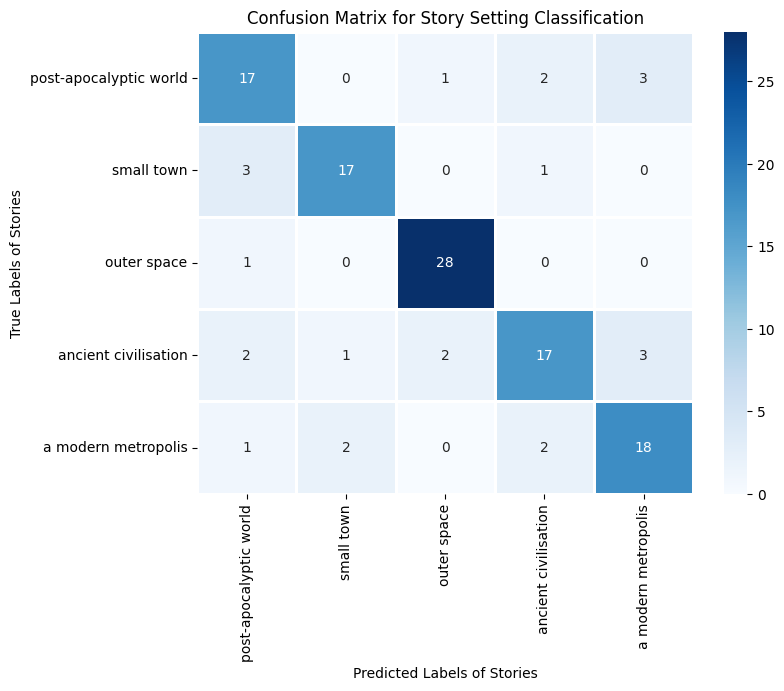

In [49]:
y_pred = rand_clf.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy using Word2Vec: {accuracy:.4f}")

# Classification Report
print("\nClassification Report using Word2vec:\n", classification_report(y_test, y_pred, target_names=label_mapping.keys()))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert confusion matrix into DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_mapping.keys(), columns=label_mapping.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=1)
plt.xlabel("Predicted Labels of Stories")
plt.ylabel("True Labels of Stories")
plt.title("Confusion Matrix for Story Setting Classification")
plt.show()

# Evaluating model by predicting the Setting of given Story

In [111]:
def predict_story_setting(story_text):
    """
    Predicts the setting label of a given story using the trained RandomForest model.
    """
    # Preprocessing the text
    words = preprocess_text(story_text)

    # Getting Word2Vec embeddings and compute average
    word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    
    if len(word_vectors) == 0:
        story_vector = np.zeros(300)  # Use zero vector if no valid embeddings
    else:
        story_vector = np.mean(word_vectors, axis=0)

    # Reshaping for model input
    story_vector = story_vector.reshape(1, -1)

    # Prediction using the trained classifier
    predicted_label = rand_clf.predict(story_vector)[0]

    # Convert numerical label back to category name
    setting_name = {v: k for k, v in label_mapping.items()}[predicted_label]
    
    return setting_name

# Trying to predict the Setting of a Story from the Dataset
story_index = 10 
 # Getting story content
story_text = df_story.loc[df_story["index"] == story_index, "text"].values[0] 
predicted_setting = predict_story_setting(story_text)

print(f"\nPredicted Setting for Story {story_index}: {predicted_setting}")



Predicted Setting for Story 10: a modern metropolis


In [37]:
data["stories"][10]

{'index': 10,
 'theme': 'rebellion',
 'setting': 'a modern metropolis',
 'person': 'explorer',
 'style': 'journalistic',
 'outcome': 'defeat',
 'object_concept': 'coat',
 'story': "In a city teeming with life, a series of events to defy the order of society transpired. Amongst the towering steel jungle were pockets of resistance like shards of a fractal, each independent yet unified in their struggle. The instigator of this quiet defiance: a man known to trade tales and traverse regions few dared to venture, clad in a coat of ever-changing hues.\\n\\nHe starts each day at the break of dawn. Where others wandered through the labyrinth of brick and mortar, he slipped through the interstices of society, finding uncharted territories within the familiar. His coat, an amalgamation of patches, was a testament to his adventures and the commitment that led him to uncover hidden lore of which few were aware.\\n\\nEach patch his coat bore was a symbol of unspoken camaraderie, a promise of rememb

In [39]:
story_index = 20  # Change this to any story index you want to test
story_text = df_story.loc[df_story["index"] == story_index, "text"].values[0]  # Get story content
predicted_setting = predict_story_setting(story_text)

print(f"\nPredicted Setting for Story {story_index}: {predicted_setting}")



Predicted Setting for Story 20: small town


In [41]:
data["stories"][20]

{'index': 20,
 'theme': 'discovery',
 'setting': 'small town',
 'person': 'explorer',
 'style': 'poetic',
 'outcome': 'defeat',
 'object_concept': 'lion',
 'story': "In a realm where structures of timber and stone stood sparse, nestled between veils of uninterrupted wilderness, he came, a seeker of the unseen and the yet-to-be-known. Of forgotten paths and hidden truths, his heart pulsed in beat to the tantalizing pull of uncharted lands. An unyielding traveller, ardent and bold, guided by whispers feathered on the wind's breath, he roved across the teeming expanse, threadbare map at his calloused fingertips.\\n\\nIn the heart of this pastoral dance, nestled a heart, beating amidst the verdant sprawl and the cerulean void yawning above. Circumscribed within its humble borders held an unspoken mystery, beguiling; waiting. To this secluded world, the journeyman meandered, drawn like a moth to the flame of lore pulsating from its core.\\n\\nA day was birthed under the benevolent watch of 

In [43]:
story_index = 12  # Change this to any story index you want to test
story_text = df_story.loc[df_story["index"] == story_index, "text"].values[0]  # Get story content
predicted_setting = predict_story_setting(story_text)

print(f"\nPredicted Setting for Story {story_index}: {predicted_setting}")


Predicted Setting for Story 12: ancient civilisation


In [45]:
data["stories"][12]

{'index': 12,
 'theme': 'betrayal',
 'setting': 'a modern metropolis',
 'person': 'explorer',
 'style': 'concise',
 'outcome': 'victory',
 'object_concept': 'piano',
 'story': "In a city of glass towers and neon lights, lived a man, Sam. His passion was to navigate the maze of a city life, unfurling its hidden secrets. It was a playground vast and pulsating, filled with life yet lonely as the moonscape. \\n\\nHe had a friend, a devoted companion, Mike. Their bond was reminiscent of old tales, built on mutual respect and trust. They crossed many milestones, meandering through the labyrinth of the city.\\n\\nBut greed knows no bar.\\n\\nOne chilly December night, Mike took Sam to a high-rise building. An ominous shadow, it stood tall under the moonlight. As they reached the penthouse, Mike pointed towards a gleaming artefact. A piano, old yet elegant, stood out against the modern aesthetics of the room. Intrigued, Sam's explorer spirit unearthed a secret compartment, revealing a small tr

# Trying to give new piece of text to predict the setting

In [47]:
new_story = "The spaceship landed on Mars, and the crew explored the red planet."
print(predict_story_setting(new_story))

new_story2 = """Scholars and warriors walked the grand stone streets, whispering secrets of the gods and the stars.But as time passed, 
                sand and silence swallowed their empire, leaving only ruins and forgotten legends."""
print(predict_story_setting(new_story2))

new_story_trick = """The spaceship landed on Mars, and the crew explored the red planet.But as time passed, 
                sand and silence swallowed their empire, leaving only ruins and forgotten legends."""
print(predict_story_setting(new_story_trick))

outer space
ancient civilisation
outer space


**Above Output: Predicted well in first samples but failed to pedict the third new_story_trick**

In [1]:
import torch

torch.mps.empty_cache()  # Clears any unused memory allocated by MPS


# ------------------2.2	Text classification with BERT-----------------

In [3]:
!pip install transformers


# Importing important packages and libraries for Section 2.2 (BERT for Text Classification)

In [119]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, DataCollatorWithPadding

from transformers import BertConfig, set_seed
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm  # Progress bar
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.model_selection import train_test_split

**To avoid warnings and error came during first run**

In [121]:
# Disabling parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Clear MPS Memory Before Training
torch.mps.empty_cache()

# Loading Tokenizer & pre-train BERT Model

In [125]:
SEED=40457510
set_seed(40457510)
CHECKPOINT = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Loading BERT model for classification

In [127]:
model_Hina = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=5).to(device)


# Enable memory-efficient training
model_Hina.gradient_checkpointing_enable()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
# Checking number of samples - Debugging Information
print(f"Train Indices from Phase 3: {len(train_indices)}") 
print(f"Test Indices from Phase 3: {len(test_indices)}")

Train Indices from Phase 3: 481
Test Indices from Phase 3: 121


# Using Train-Test Split from Section 2.1 

In [131]:
train_texts = df_story.loc[train_indices, "text"].tolist()  
test_texts = df_story.loc[test_indices, "text"].tolist()
y_train = df_story.loc[train_indices, "setting_label"].tolist()
y_test = df_story.loc[test_indices, "setting_label"].tolist()

# Printing dataset sizes to confirm
print(f"Train Samples: {len(train_texts)}")
print(f"Test Samples: {len(test_texts)}")

Train Samples: 481
Test Samples: 121


In [ ]:
# Creating Validation Set (Splitting Train into 80% Train, 20% Validation)

In [133]:

train_texts, val_texts, y_train, y_val = train_test_split(
    train_texts, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

In [135]:
#  Print dataset sizes again
print(f"Train Samples: {len(train_texts)}")
print(f"Validation Samples: {len(val_texts)}")
print(f"Test Samples: {len(test_texts)}")

Train Samples: 384
Validation Samples: 97
Test Samples: 121


# Tokenizing Text for BERT

In [137]:
MAX_LEN = 512

train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
val_encodings = tokenizer(val_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Converting labels to tensors

In [139]:
#  Convert labels to tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

In [141]:
# DataCollator for Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Creating PyTorch Dataset

In [143]:
class StoryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create Dataset Objects
train_dataset = StoryDataset(train_encodings, train_labels)
val_dataset = StoryDataset(val_encodings, val_labels)
test_dataset = StoryDataset(test_encodings, test_labels)

# Defining Optimizer, Scheduler and Fine Tuning

In [145]:
#optimizer = AdamW(model_Hina.parameters(), lr=2e-5, weight_decay=0.01)
optimizer = AdamW(model_Hina.parameters(), lr=2e-5, weight_decay=0.01, no_deprecation_warning=True)
BATCH_SIZE = 4
EPOCHS = 5

# Adjusting num_training_steps
num_training_steps = (len(train_dataset) // BATCH_SIZE) * EPOCHS

lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Creating DataLoader

In [147]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

# Training BERT Model with batch size=4, epochs=5, learning rate=2e-5

Training Progress:   0%|                                  | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.7978 - Train Accuracy: 0.2526 - Val Loss: 1.3997 - Val Accuracy: 0.7010
Epoch 2/5 - Train Loss: 0.4864 - Train Accuracy: 0.7839 - Val Loss: 0.5447 - Val Accuracy: 0.8763
Epoch 3/5 - Train Loss: 0.1795 - Train Accuracy: 0.9609 - Val Loss: 0.2450 - Val Accuracy: 0.9588
Epoch 4/5 - Train Loss: 0.0708 - Train Accuracy: 0.9922 - Val Loss: 0.1470 - Val Accuracy: 0.9691
Epoch 5/5 - Train Loss: 0.0367 - Train Accuracy: 1.0000 - Val Loss: 0.1240 - Val Accuracy: 0.9794


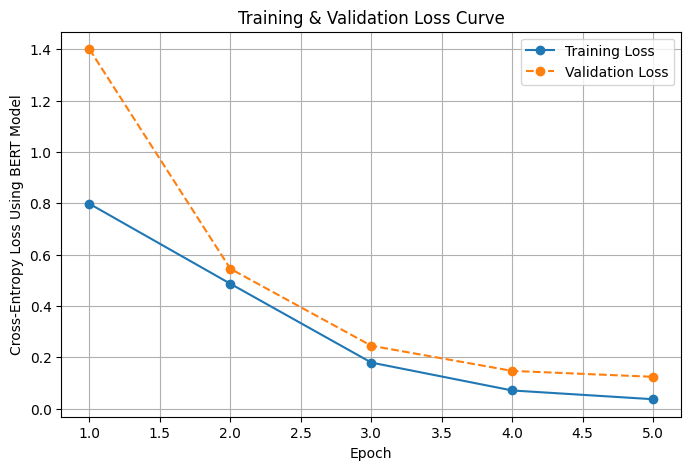

In [149]:
ACCUMULATION_STEPS = 2
torch.mps.empty_cache()

progress_bar = tqdm(range(EPOCHS), desc="Training Progress", leave=True, dynamic_ncols=True)

# Track Loss for Visualization
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model_Hina.train()
    total_train_loss = 0
    train_preds, train_true = [], []

    for i, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_Hina(**batch)
        loss = outputs.loss / ACCUMULATION_STEPS
        total_train_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        train_preds.extend(predictions)
        train_true.extend(batch["labels"].cpu().numpy())

        loss.backward()

        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

#  Compute Training & Validation Accuracy
    train_accuracy = accuracy_score(train_true, train_preds)
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #  Validate Model After Each Epoch
    model_Hina.eval()
    total_val_loss = 0
    val_preds, val_true = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_Hina(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            val_preds.extend(predictions)
            val_true.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(val_true, val_preds)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
    progress_bar.update(1)  #  Updates progress after each epoch
    progress_bar.refresh()

# --- Plot Training and Validation Loss Curve ---
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o', linestyle="dashed")

# Labels and Title
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss Using BERT Model')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

# Evaluating Model on Test Data


 Final Test Accuracy of BERT Model: 0.9504

 Classification Report for Story Setting Classification using Pre-Trained BERT Model:
                        precision    recall  f1-score   support

post-apocalyptic world       0.84      0.91      0.88        23
            small town       1.00      0.90      0.95        21
           outer space       0.97      1.00      0.98        29
  ancient civilisation       0.96      0.92      0.94        25
   a modern metropolis       1.00      1.00      1.00        23

              accuracy                           0.95       121
             macro avg       0.95      0.95      0.95       121
          weighted avg       0.95      0.95      0.95       121



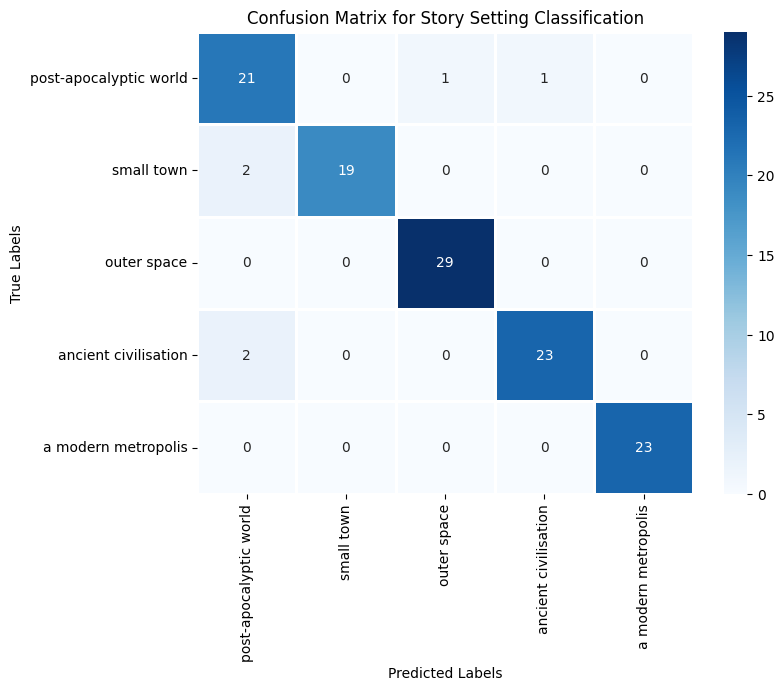

In [151]:
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_Hina(**batch)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_preds.extend(predictions)

test_accuracy = accuracy_score(test_labels.cpu().numpy(), test_preds)
print(f"\n Final Test Accuracy of BERT Model: {test_accuracy:.4f}")

#  Display Classification Report
print("\n Classification Report for Story Setting Classification using Pre-Trained BERT Model:")
print(classification_report(test_labels.cpu().numpy(), test_preds, target_names=list(label_mapping.keys()), zero_division=1))


# Compute Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_mapping.keys(), columns=label_mapping.keys())
# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=1)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Story Setting Classification")
plt.show()

In [185]:
# Saving the fine-tuned model and tokenizer
model_Hina.save_pretrained("Hina_fine_tuned_bert_model")
tokenizer.save_pretrained("Hina_fine_tuned_bert_model")

('Hina_fine_tuned_bert_model/tokenizer_config.json',
 'Hina_fine_tuned_bert_model/special_tokens_map.json',
 'Hina_fine_tuned_bert_model/vocab.txt',
 'Hina_fine_tuned_bert_model/added_tokens.json',
 'Hina_fine_tuned_bert_model/tokenizer.json')